# Sarsa and Q-learning for Cliff Walking

## Game-code

In [1]:
## Cliff walking game
%matplotlib inline
import numpy as np
from python_utils import *
import matplotlib.pyplot as plt

# Game setup
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
actions = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

startState = [3, 0]
goalState = [3, 11]


# Initial Q-function
stateActionValues = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))


# state-action scores
actionRewards = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
actionRewards[:, :, :] = -1
actionRewards[2, 1:11, ACTION_DOWN] = -100.0  # Falling into the cliff
actionRewards[3, 0, ACTION_RIGHT] = -100.0


# Game algorithm giving next_state & reward & termination
def step(currentState, action):
    current_x = currentState[0]
    current_y = currentState[1]
    
    nextState = []
    
    if (action == ACTION_UP):
        next_x = max(0, current_x - 1)
        next_y = current_y
    elif (action == ACTION_DOWN):
        next_x = min(3, current_x + 1)
        next_y = current_y
    elif (action == ACTION_LEFT):
        next_x = current_x
        next_y = max(0, current_y - 1)
    else:
        next_x = current_x
        next_y = min(11, current_y + 1)
    
    if (currentState == startState and action == ACTION_RIGHT): ## Falling into the cliff at the start state
        next_x = startState[0]
        next_y = startState[1]
        
    if (next_x == 3 and 1<= next_y <= 10):
        nextState = startState
    else:
        nextState = [next_x, next_y]
        
    reward = actionRewards[currentState[0], currentState[1], action]
    
    if (nextState == goalState):
        terminal = True
    else:
        terminal = False
        
    return nextState, reward, terminal
    


### Function of $\epsilon$-greedy action selection

In [2]:
def chooseAction(state, stateActionValues, epsilon):
    if np.random.binomial(1, epsilon) == 1:    # Exploration with probability epsilon
        return np.random.choice(actions)
    else:                                      # Greedy action selection
        return np.argmax(stateActionValues[state[0], state[1], :])

### Global Variables : Hyper Parameters of the model

In [3]:
EPSILON = 0.1   # epsilon-greedy action selection
ALPHA = 0.5     # Learning rate
GAMMA = 1.0     # Discount factor

## Running with SARSA algorithm

#### - Please fill out the missing parts of the code

In [4]:
def sarsa(stateActionValues, stepsize = ALPHA):
    
    currentState = startState
    currentAction = chooseAction(currentState, stateActionValues, EPSILON)
    accumulatedRewards = 0.0
    terminal = False
    
    while terminal != True:
        
        # 1. Step the current action a & Observe the next_state, reward, terminal
        newState, reward, terminal = step(currentState, currentAction)
        
        # 2. Choose new action by ON-POLICY on the next_state
        newAction = chooseAction(newState, stateActionValues, EPSILON)
        
        # 3. Incremental update of Q-function
        newStateActionValue = stateActionValues[newState[0], newState[1], newAction]
        
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (reward + GAMMA * newStateActionValue - stateActionValues[currentState[0], currentState[1], currentAction])
        
        # 4. Update the timestep
        currentState = newState
        currentAction = newAction
        
        # 5. Accumulation of reward
        accumulatedRewards += reward
        
    return accumulatedRewards

## Running with SARSA algorithm

#### - Please fill out the missing parts of the code

In [5]:
def qLearning(stateActionValues, stepsize = ALPHA):
    
    currentState = startState
    accumulatedRewards = 0.0
    terminal = False
    
    while terminal != True:
        
        # 1. Choose the action from Q-function
        currentAction = chooseAction(currentState, stateActionValues, EPSILON)
        
        # 2. Step the current action a & Observe the next_state, reward, terminal
        newState,reward, terminal = step(currentState, currentAction)
        
        # 3. Choose new action by OFF-POLICY on the next_state & Find the new Q-value 
        newStateActionValue = np.max(stateActionValues[newState[0], newState[1], :])
        
        # 4. Incremental update of Q-function
        stateActionValues[currentState[0], currentState[1], currentAction] += \
            ALPHA * (reward + GAMMA * newStateActionValue - stateActionValues[currentState[0], currentState[1], currentAction])
            
        # 5. Update the timestep
        currentState = newState
        
        # 6. Accumulation of reward
        accumulatedRewards += reward
        
    return accumulatedRewards

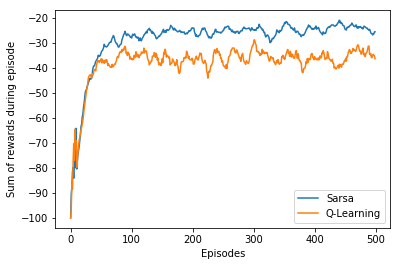

In [6]:
# episodes of each run
nEpisodes = 500

# perform 20 independent runs
runs = 20

rewardsSarsa = np.zeros(nEpisodes)
rewardsQLearning = np.zeros(nEpisodes)
for run in range(0, runs):
    stateActionValuesSarsa = np.copy(stateActionValues)
    stateActionValuesQLearning = np.copy(stateActionValues)
    for i in range(0, nEpisodes):
        # cut off the value by -100 to draw the figure more elegantly
        # whenever you call sarsa(Q), or qLearning(Q), 
        # it will update Q and give you the accumulated reward resulted from the current ep.
        rewardsSarsa[i] += max(sarsa(stateActionValuesSarsa), -100)
        rewardsQLearning[i] += max(qLearning(stateActionValuesQLearning), -100)

# averaging over independt runs
rewardsSarsa /= runs
rewardsQLearning /= runs

# Smoothing the episodic rewards
averageRange = 10
smoothedRewardsSarsa = np.copy(rewardsSarsa)
smoothedRewardsQLearning = np.copy(rewardsQLearning)
for i in range(averageRange, nEpisodes):
    smoothedRewardsSarsa[i] = np.mean(rewardsSarsa[i - averageRange: i + 1])
    smoothedRewardsQLearning[i] = np.mean(rewardsQLearning[i - averageRange: i + 1])

# draw reward curves
plt.figure(1)
plt.plot(smoothedRewardsSarsa, label='Sarsa')
plt.plot(smoothedRewardsQLearning, label='Q-Learning')
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.legend()


In [7]:
# print optimal policy
def printOptimalPolicy(stateActionValues):
    optimalPolicy = []
    for i in range(0, WORLD_HEIGHT):
        optimalPolicy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == goalState:
                optimalPolicy[-1].append('G')
                continue
            bestAction = np.argmax(stateActionValues[i, j, :])
            if bestAction == ACTION_UP:
                optimalPolicy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimalPolicy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimalPolicy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimalPolicy[-1].append('R')
    for row in optimalPolicy:
        print (row)

# display optimal policy
print ('Sarsa Optimal Policy:')
printOptimalPolicy(stateActionValuesSarsa)
print ('Q-Learning Optimal Policy:')
printOptimalPolicy(stateActionValuesQLearning)

Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'U', 'U', 'R', 'U', 'L', 'R', 'D']
['U', 'U', 'L', 'U', 'U', 'U', 'U', 'U', 'R', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['R', 'R', 'U', 'R', 'R', 'R', 'U', 'R', 'R', 'U', 'R', 'D']
['D', 'U', 'R', 'R', 'R', 'R', 'D', 'R', 'R', 'D', 'R', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
